<a href="https://colab.research.google.com/github/karsarobert/Deep-Learning-2022/blob/main/12/PTE_DL12_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning gyakorlat


## 12. gyakorlat: ajánlórendszer
### 2022. november 30.

forrás: https://github.com/prateekjoshi565/recommendation_system/blob/master/recommender_2.ipynb

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')

![áruból szavak](https://cdn.analyticsvidhya.com/wp-content/uploads/2019/07/img_9.png)

Vessünk egy gyors pillantást az adatainkra. Letöltheted [innen](https://archive.ics.uci.edu/ml/machine-learning-databases/00352/).

https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



InvoiceNo: Számlaszám. minden tranzakcióhoz egyedi szám tartozik

Raktárkód: Termék/cikk kód. minden egyes termékhez egyedi szám tartozik

Leírás: Termékleírás 

Mennyiség: Az egyes termékek mennyisége tranzakciónként

InvoiceDate: Számla dátuma és időpontja. Az egyes tranzakciók létrehozásának napja és időpontja

Ügyfélazonosító: Ügyfélszám. minden ügyfélhez egyedi számot rendelnek

In [4]:
df.shape

(541909, 8)

Az adatkészlet 541 909 tranzakciót tartalmaz. Ez számunkra elég jó szám.

## Hiányzó adatok kezelése

In [5]:
# check for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

<br>
Mivel elegendő adatunk van, az összes hiányzó értékkel rendelkező sort elhagyjuk.

In [6]:
# remove missing values
df.dropna(inplace=True)

# again check missing values
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Adatok előkészítése

Konvertáljuk a StockCode-ot string adattípussá.

In [7]:
df['StockCode']= df['StockCode'].astype(str)

Nézzük meg az egyedi ügyfelek számát az adatállományunkban.

In [8]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [9]:
customers[:10]

[17850.0,
 13047.0,
 12583.0,
 13748.0,
 15100.0,
 15291.0,
 14688.0,
 17809.0,
 15311.0,
 14527.0]

Adatállományunkban 4372 ügyfél szerepel. 

Jó gyakorlat, ha az adatállomány egy kis részét elkülönítjük validálási célokra. Ezért az ügyfelek 90%-ának adatait fogom használni a word2vec beágyazások létrehozásához. Osszuk fel az adatokat.

In [10]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
train_df = df[df['CustomerID'].isin(customers_train)]
validation_df = df[~df['CustomerID'].isin(customers_train)]

In [11]:
from sklearn.model_selection import train_test_split

train_df, validation_df = train_test_split(df, train_size=0.9, random_state = 0)

In [12]:
train_df.info

<bound method DataFrame.info of        InvoiceNo StockCode                          Description  Quantity  \
173198    551658     20724          RED RETROSPOT CHARLOTTE BAG        10   
403638    571653    85034B    3 WHITE CHOC MORRIS BOXED CANDLES        24   
222056    556325     22138        BAKING SET 9 PIECE RETROSPOT          3   
541658    581538     22469                HEART OF WICKER SMALL         1   
54587     540957    82001S            VINYL RECORD FRAME SILVER        24   
...          ...       ...                                  ...       ...   
477422    577057     21425             SKULLS STORAGE BOX LARGE         1   
475721    576911     23697              A PRETTY THANK YOU CARD        12   
213726    555553    84997B     CHILDRENS CUTLERY RETROSPOT RED          4   
169166    551170     22193                 RED DINER WALL CLOCK         5   
410119    572092     21464  DISCO BALL ROTATOR BATTERY OPERATED         3   

               InvoiceDate  UnitPrice  Cust

Hozzuk létre a vásárlók által az adathalmazban végrehajtott vásárlások sorozatát mind a képzési, mind a validálási halmazban.

In [13]:
# lista az ügyfelek vásárlási előzményeinek rögzítésére

purchases_train = []

# töltse fel a listát a termékkódokkal
for i in tqdm(customers_train):
    temp = train_df[train_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)

100%|██████████| 3935/3935 [00:02<00:00, 1640.40it/s]


In [14]:
purchases_train[:1]

[['22847',
  '84078A',
  '22624',
  '23052',
  '21896',
  '22845',
  '22960',
  '21288',
  '22962',
  '22191',
  '22176',
  '22666',
  '22781',
  '22720',
  '22781',
  '22494',
  '23054',
  '21770',
  '16016',
  '22467',
  'POST',
  '15056BL',
  '82484',
  '22173',
  'POST',
  '22366']]

In [15]:
# lista az ügyfelek vásárlási előzményeinek rögzítésére

purchases_val = []

# töltse fel a listát a termékkódokkal
for i in tqdm(validation_df['CustomerID'].unique()):
    temp = validation_df[validation_df["CustomerID"] == i]["StockCode"].tolist()
    purchases_val.append(temp)

100%|██████████| 3818/3818 [00:01<00:00, 2556.93it/s]


## Build word2vec Embeddings for Products

In [16]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(3288127, 3322490)

In [17]:
# save word2vec model
model.save("word2vec_2.model")

Mivel nem tervezzük tovább képezni a modellt, meghívjuk az init_sims() funkciót, ami sokkal memóriahatékonyabbá teszi a modellt.

In [18]:
model.init_sims(replace=True)

In [19]:
print(model)

Word2Vec(vocab=3128, size=100, alpha=0.03)


Most kivonjuk a szókincsünkben szereplő összes szó vektorát, és egy helyen tároljuk a könnyű hozzáférés érdekében.

In [20]:
# extract all vectors
X = model[model.wv.vocab]

X.shape

(3128, 100)

Modellünk szókincse 3180 egyedi szóból áll, és ezek vektorai egyenként 100 méretűek.

## Word2vec beágyazások vizualizálása

Mindig nagyon hasznos a létrehozott beágyazások vizualizálása. Itt 100 dimenziós beágyazások vannak. Még 4 dimenziót sem tudunk megjeleníteni, nemhogy 100-at. Ezért az TSNE algoritmus segítségével csökkenteni fogjuk a termék beágyazásainak dimenzióit 100-ról 2-re, ezt a dimenziócsökkentésre használják. 

In [21]:
import sklearn.manifold
tsne_op = sklearn.manifold.TSNE(n_components=2, perplexity=30)
cluster_embedding = tsne_op.fit_transform(X)

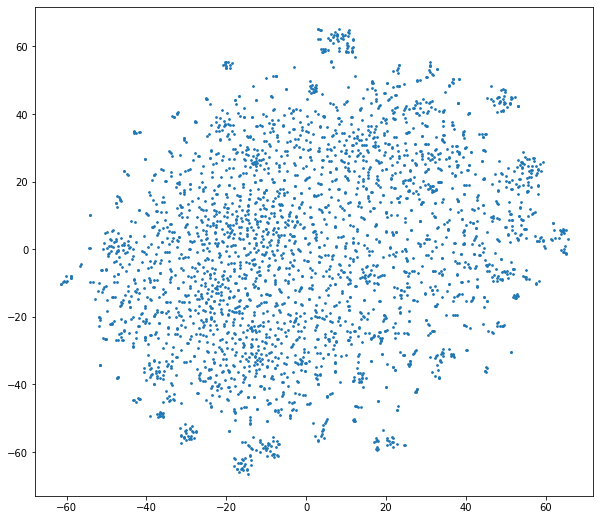

In [22]:
plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

A diagramon minden egyes pont egy termék. Mint látható, az adatpontok több apró klaszterben helyezkednek el. Ezek hasonló termékek csoportjai.

## Termékek ajánlása

Elkészültünk a word2vec beágyazásokkal az online kiskereskedelmi adathalmazunk minden termékéhez. Most a következő lépésünk az, hogy egy adott termékhez vagy termékvektorhoz hasonló termékeket javasoljunk.

Először hozzunk létre egy termékazonosító és termékleírás szótárat, hogy könnyedén hozzárendelhessük a termék leírását az azonosítójához és fordítva.

In [23]:
#products = train_df[["StockCode", "Description"]]
products = df[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [24]:
# test the dictionary
products_dict['84029E']

['RED WOOLLY HOTTIE WHITE HEART.']

<br>
Az alábbiakban definiáltam a függvényt. Ez egy termék vektorát (n) veszi bemenetként, és a 6 legjobb hasonló terméket adja vissza.

In [25]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

Próbáljuk ki a függvényünket a termék vektorának átadásával '90019A' ('SILVER M.O.P ORBIT BRACELET')

In [26]:
similar_products(model['90019A'])

[('AMBER DROP EARRINGS W LONG BEADS', 0.7192391157150269),
 ('DANISH ROSE TRINKET TRAYS', 0.7110270261764526),
 ('DROP DIAMANTE EARRINGS PURPLE', 0.6917407512664795),
 ('DANISH ROSE DECORATIVE PLATE', 0.6785832643508911),
 ('FRENCH FLORAL CUSHION COVER ', 0.6566711664199829),
 ('RED POLKADOT COFFEE  MUG', 0.6363409757614136)]

<br>

Az eredmények elég relevánsak és jól illeszkednek a bemeneti termékhez. Ez a kimenet azonban csak egyetlen termék vektorán alapul. Mi van akkor, ha a felhasználónak termékeket szeretnénk ajánlani a múltbeli több vásárlása alapján?

Egy egyszerű megoldás, ha az eddig vásárolt termékek vektorainak átlagát vesszük, és ezt az eredményvektort használjuk a hasonló termékek keresésére. Ehhez az alábbi függvényt fogjuk használni, amely egy termékazonosító listát vesz fel, és egy 100 dimenziós vektort ad ki, amely a bemeneti listában szereplő termékek vektorainak átlaga.


In [27]:
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
        
    return np.mean(product_vec, axis=0)

In [28]:
products

,StockCode,Description
107,84854,GIRLY PINK TOOL SET
902,21895,POTTING SHED SOW 'N' GROW SET
1985,20957,PORCELAIN HANGING BELL SMALL
2313,82615,PINK MARSHMALLOW SCARF KNITTING KIT
2457,21488,RED WHITE SCARF HOT WATER BOTTLE
...,...,...
541904,22613,PACK OF 20 SPACEBOY NAPKINS
541905,22899,CHILDREN'S APRON DOLLY GIRL
541906,23254,CHILDRENS CUTLERY DOLLY GIRL
541907,23255,CHILDRENS CUTLERY CIRCUS PARADE


Már létrehoztunk egy külön listát a vásárlási szekvenciákról az érvényesítés céljából. Most pedig használjuk fel ezt.

In [29]:
len(purchases_val[2])

34

A felhasználó által megvásárolt termékek listájának hossza ez. Ezt a terméksorozatot az érvényesítési halmazból átadjuk az *aggregate_vectors* függvénynek.

In [30]:
aggregate_vectors(purchases_val[0]).shape

(100,)

Nos, a függvény egy 100 dimenziós tömböt adott vissza. Ez azt jelenti, hogy a függvény jól működik. Most ezt az eredményt felhasználhatjuk a leghasonlóbb termékek kiválasztásához. Tegyük ezt meg.

In [31]:
similar_products(aggregate_vectors(purchases_val[0]))

[('JUMBO BAG RED RETROSPOT', 0.7385562658309937),
 ('LUNCH BAG RED RETROSPOT', 0.6947067975997925),
 ('JUMBO BAG VINTAGE LEAF', 0.6878343224525452),
 ('PURPLE ACRYLIC FACETED BANGLE', 0.6834182739257812),
 ('LUNCH BAG PINK POLKADOT', 0.6809910535812378),
 ('ENGLISH ROSE NOTEBOOK A6 SIZE', 0.6781306266784668)]

Mint kiderült, rendszerünk 6 terméket ajánlott a felhasználó teljes vásárlási előzményei alapján. Sőt, ha csak a legutóbbi néhány vásárlás alapján szeretne termékjavaslatokat kapni, akkor is használhatja ugyanezt a funkciókészletet.

Az alábbiakban csak az utolsó 10 megvásárolt terméket adom meg bemenetként.

In [32]:
similar_products(aggregate_vectors(purchases_val[0][-10:]))

[('DOORMAT NEIGHBOURHOOD WITCH ', 0.6641659140586853),
 ('POTTING SHED ROSE CANDLE', 0.6530492305755615),
 ('BATHROOM SCALES RUBBER DUCKS', 0.6517224311828613),
 ('WHITE MOROCCAN METAL LANTERN', 0.6463543176651001),
 ('JUMBO BAG RED RETROSPOT', 0.6315622925758362),
 ('FROSTED WHITE BASE ', 0.6278648376464844)]

Nyugodtan játsszon ezzel a kóddal, próbáljon meg termékajánlást kapni további szekvenciákhoz a validációs készletből.